In [1]:
#@Chhy

#Script to pick up and crop frames from the raw data.

# files location and name

data_file = './Data/ma6002/'
main_file = data_file + 'WMG LNO SC_1 4200mV_BCDI.h5'
flat_field_file = data_file + 'ff_20240423-0736/ff.npz'

save_root = './Data/pick_up/'

# interested scan 

scan_numbers = [6, 9, 12, 15, 18, 21, 24, 27, 30, 33]
select_scan = 6
begin, end = 300, -126

flat_field_correction = 0

In [2]:
import hdf5plugin
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys, os

In [3]:
try:
    os.mkdir(save_root)
except:
    print("saving root folder is already exist!")

saving root folder is already exist!


In [4]:
flat_field_ = np.load(flat_field_file)['arr_0'][:]

In [5]:
# check the flat_field_file and one of the scan e.g. 21
with h5py.File(main_file) as fp:
    title = fp['%i.1/title'%scan_numbers[select_scan]][()]
    gonphi = fp['%i.1/instrument/phi/value'%scan_numbers[select_scan]][:]
    data_ = fp['%i.1/measurement/mpxgaas'%scan_numbers[select_scan]][:].astype(int)
print(data_.shape)

(1000, 516, 516)


579


/tmp/ipykernel_2928527/3224012056.py:8: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(data_[peak_pos]))
/tmp/ipykernel_2928527/3224012056.py:11: RuntimeWarning: divide by zero encountered in log10
  axs[1].imshow(np.log10(corrected_frame))
/tmp/ipykernel_2928527/3224012056.py:11: RuntimeWarning: invalid value encountered in log10
  axs[1].imshow(np.log10(corrected_frame))
/tmp/ipykernel_2928527/3224012056.py:14: RuntimeWarning: divide by zero encountered in log10
  axs[2].imshow(np.log10(flat_field_))


Text(0.5, 1.0, 'flat field')

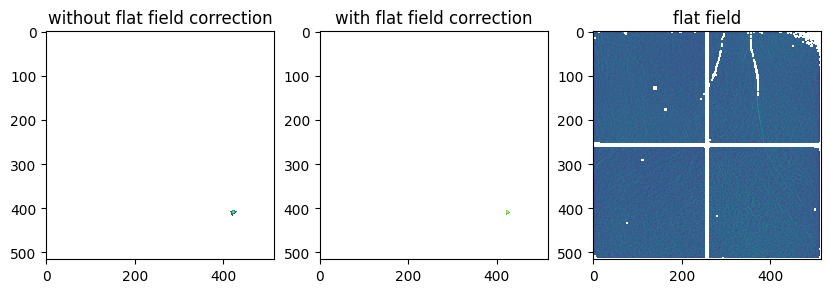

In [11]:
rc_data_ori = np.sum(data_, axis=(1,2))
peak_pos = np.argmax(rc_data_ori)
print(peak_pos)
corrected_frame = data_[peak_pos]-flat_field_

fig, axs = plt.subplots(1,3, figsize=(10, 30))

axs[0].imshow(np.log10(data_[peak_pos]))
axs[0].set_title('without flat field correction')

axs[1].imshow(np.log10(corrected_frame))
axs[1].set_title('with flat field correction')

axs[2].imshow(np.log10(flat_field_))
axs[2].set_title('flat field')


(409, 423) 3488
0 0 0 0


/tmp/ipykernel_2928527/664560366.py:33: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(burst[pos_]))
/tmp/ipykernel_2928527/664560366.py:37: RuntimeWarning: invalid value encountered in log10
  axs[1].imshow(np.log10(corrected_[pos_]))
/tmp/ipykernel_2928527/664560366.py:44: RuntimeWarning: invalid value encountered in log10
  axs[3].imshow(np.log10(np.sum(corrected_, axis=0)))


0 3318
-84.96231079101562 3317.1180343031883


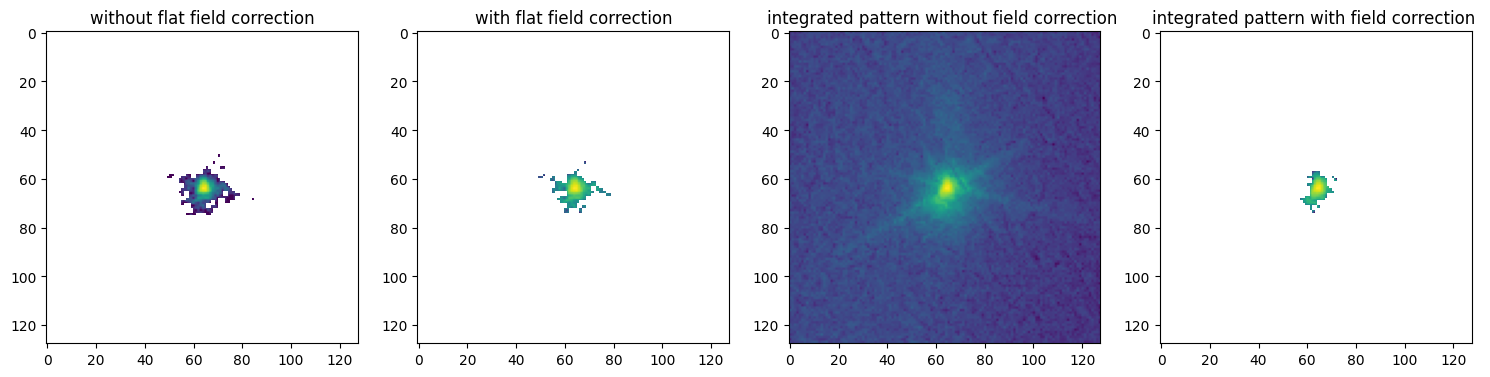

In [8]:
burst = np.copy(data_)
pos_ = peak_pos
burst[burst==11810]=0

brightest = np.unravel_index(np.argmax(burst), burst.shape)[0]
center = np.unravel_index(np.argmax(burst[brightest]), burst[brightest].shape)
print(center, burst.max())


# crop the whole burst around this pixelß
shape = int(128)
before_i = -min(center[0] - shape/2, 0)
before_j = int(-min(center[1] - shape/2, 0))
after_i = max(center[0] + shape/2 - burst.shape[-2], 0)
after_j = int(max(center[1] + shape/2 - burst.shape[-1], 0))
print(before_i, before_j, after_i, after_j)

burst = np.pad(burst, 
               pad_width=((0, 0), (before_i, after_i), (before_j, after_j)),
               mode='constant', constant_values=0)
burst = burst[:,
              before_i+center[0]-shape//2:before_i+center[0]+shape//2,
              before_j+center[1]-shape//2:before_j+center[1]+shape//2]


flat_field_crop = flat_field_[before_i+center[0]-shape//2:before_i+center[0]+shape//2,before_j+center[1]-shape//2:before_j+center[1]+shape//2]
#flat_field_crop = np.pad(flat_field_crop, pad_width=((before_i, after_i), (before_j, after_j)),mode='constant', constant_values=0)
corrected_ = burst-flat_field_crop[None, :, :]


fig, axs = plt.subplots(1,4, figsize=(15, 60))

axs[0].imshow(np.log10(burst[pos_]))
axs[0].set_title('without flat field correction')
print(burst[peak_pos].min(), burst[peak_pos].max())

axs[1].imshow(np.log10(corrected_[pos_]))
axs[1].set_title('with flat field correction')
print(corrected_frame.min(), corrected_frame.max())

axs[2].imshow(np.log10(np.sum(burst, axis=0)))
axs[2].set_title('integrated pattern without field correction ')

axs[3].imshow(np.log10(np.sum(corrected_, axis=0)))
axs[3].set_title('integrated pattern with field correction ')

plt.tight_layout()


Text(0.5, 1.0, 'rocking curve in log mode of scan 24')

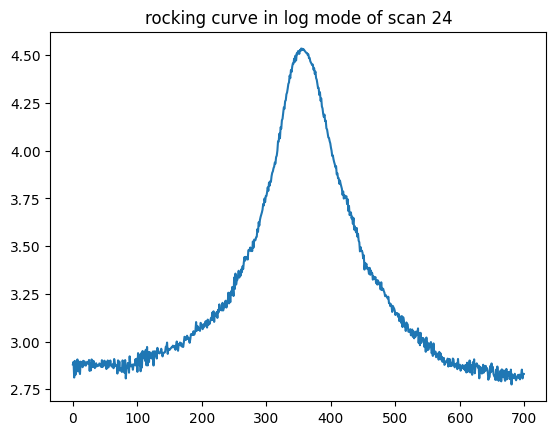

In [9]:
rc_crop = np.sum(burst, axis = (1,2))

begin = 225
end = -75

plt.plot(np.log10(rc_crop[begin:end]))
plt.title('rocking curve in log mode of scan %i'%scan_numbers[select_scan])

In [10]:
#save option 
burst_save = burst[begin:end]
print(len(burst_save))
np.savez(save_root + '/%i_%i.npz'%(scan_numbers[select_scan], shape), data=burst_save)

700
